Lending Club Loan Robot

The goal of the project is to **boost your chance of getting a loan from lending club**. 

Over the past 10 years, Lending Club has reached the market capitalization of 1.4 billion dollars with number of loans issued per year increased exponentially. Last year, 2017, they issued more than 8 million loans worth of 120 billion dollars. Considering the size of the company, clearly Lending Club does not have time to review each application, and in fact they use some algorithm to decide. So the aim of the project is to predict the outcome of lending club's algorithm. 

Various machine learning models are built and a website is built based on the best optimised model random forest. The notebook consist 5 main parts.
1. Load in data
2. Data extraction
3. EDA 
4. Model building
5. Error Analysis
6. Appendix


### 1 Load in Data
Loan data is publicly available on Lending Club Statistics as csv files. Datasets of loans issued and declined from 2007 to 2017 are downloaded and merged into two huge csv files using cat function on command line. 

Because both files have a size greater than 1G, breakdowns or freeze can happen when try to open with text editor or Python. One of the approach is to convert to sql database and filter the data before import to Python.
 


#### 1.1 Create Database from csv
Download lending-club-loan-data.zip from lending club statistics.<br> 
The zip file contains two csv (accepted and rejected).
In aws server, type
```python
wget https://resources.lendingclub.com/RejectStatsA.csv.zip
unzip RejectStatsA.csv.zip
```
Import csv to SQLite, create tables and insert csv data to the tables.<br>
SQLite is often chose when dealing with large dataset due to its excellent performance in efficiency and speed. 
```python
ubuntu> sqlite3 loan.db
sqlite> .mode csv
sqlite> .import rejected_07_17.csv tmp
sqlite> .schema tmp

CREATE TABLE rej(
    id integer primary key,
    loan_amnt FLOAT,
    application_d VARCHAR(10),
    title VARCHAR(20),
    fico FLOAT,
    dti FLOAT,
    zip_code VARCHAR(10),
    addr_state VARCHAR(10),
    emp_length VARCHAR(20),
    policy_code FLOAT);
	
INSERT INTO rej(
    loan_amnt,fico,dti,policy_code,application_d,title,zip_code,addr_state,emp_length)
SELECT 
CAST("Amount Requested" AS FLOAT),
CAST("Risk_Score" AS FLOAT),
CAST("Debt-To-Income Ratio" AS FLOAT),
CAST("Debt-To-Income Ratio" AS FLOAT),
"Application Date","Loan Title","Zip Code","State","Employment Length"
FROM tmp;

```

#### 1.2 Connect to Database
Setting up connections between sqlite with Python.<br>
**Table Names **<br>
acc :  loans issued <br>
rejected: applications rejected

Based on the previous year's findings, if fico scores are null, Lending Club will 100% reject the application. Secondly only 354 out of all 165M accepted applicantions left dti as null or negative. Therefore, we can confidently remove observations with missing fico or dti scores from the dataset. That left us with a ratio of 4:1 as rejection is 4 times more than acceptantce.

In [1]:
from sklearn import pipeline, preprocessing, neighbors, model_selection,linear_model
import seaborn as sns
import pandas as pd
import numpy as np
import sqlite3, itertools
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 250)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 20)

In [2]:
sql_file = 'DB/loan.db'
sql_line_rej = '''
SELECT loan_amnt, LOWER(title), fico, addr_state, emp_length,application_d,
CASE WHEN dti >100
THEN 100
ELSE dti
END
FROM rej 
WHERE 
    fico >1
    AND application_d > '2015-01-1' 
    AND dti > 0
    AND id%5==0
'''

sql_line_acc = '''
SELECT loan_amnt*1, LOWER(title), (fico_range_high+fico_range_low+last_fico_range_low+last_fico_range_high)/4,
addr_state, emp_length, issue_d,
CASE WHEN CAST("dti" AS FLOAT)>100
THEN 100
ELSE dti*1
END
FROM acc
WHERE 
    emp_length!='' 
    AND LENGTH(id)> 7 
    AND issue_d not like "%2013%"
    AND issue_d not like "%2014%"
    AND id%5==0
'''


In [3]:
def read_reject():
    conn = sqlite3.connect(sql_file)
    cur = conn.cursor()
    df = pd.DataFrame(cur.execute(sql_line_rej).fetchall(),columns=cols)
    return df

cols = ['loan_amnt', 'title','fico', 'addr_state', 'emp_length','application_d','dti']
rej = read_reject()

In [4]:
def read_accept():
    conn = sqlite3.connect(sql_file)
    cur = conn.cursor()
    df = pd.DataFrame(cur.execute(sql_line_acc).fetchall(),columns=cols)
    return df
acc = read_accept()


#### 1.3 Merge
- Merge dataframe acc and rej
- Add a column approved. Approved = 1 if loan request is approved, 0 if rejected.

In [5]:
acc.insert(0, 'approved',1)
rej.insert(0, 'approved',0)

In [6]:
loan = pd.concat([acc, rej]).reset_index()

For D3 Use
```python
d3_map = loan.groupby(['addr_state']).agg({'index':'count','approved':'sum'}).reset_index().rename(
    columns={'index':'count'})
d3_map['rej_rate'] = (1-d3_map.approved/d3_map['count'])*100
d3_map = d3_map.set_index('addr_state')
d3_map = d3_map[['rej_rate']]
d3_map.rej_rate.mean()
```

### 2 Data Clean
- transform title,employ length to categorical columns

In [7]:
def data_cleaning(df):
    df = df.copy()
    df['application_d'] = pd.to_datetime(df['application_d'], infer_datetime_format=True)
    d = dict.fromkeys([
        'business','refinancing','car','home','purchase','other','medical','moving','vacation'
    ], 0)
    df = df.assign(**d)
    df.loc[df['title'].str.contains('consolidat|refinan|cosolidat|refiance|credit'),'refinancing'] = 1
    df.loc[df['title'].str.contains('business'),'business'] = 1
    df.loc[df['title'].str.contains('home|house|pool|garage|kitchen|backyard|room|basement'),'home'] = 1
    df.loc[df['title'].str.contains('car'),'car'] = 1
    df.loc[df['title'].str.contains('expense|purchase'),'purchase'] = 1
    df.loc[df['title'].str.contains('medical'),'medical'] = 1
    df.loc[df['title'].str.contains('moving|relocation'),'moving'] = 1
    df.loc[df['title'].str.contains('vacation'),'vacation'] = 1
    df.loc[df['title'].str.contains('other'),'other'] = 1
    dummy1 = pd.get_dummies(df['emp_length']).iloc[:, 1:]
    dummy2 = pd.get_dummies(df['addr_state']).iloc[:, 1:]
    df = pd.concat([df,dummy1,dummy2],axis=1)
    df = df.sample(frac=1).reset_index(drop=True)
    df.drop(['title','emp_length','addr_state','index'], axis=1,inplace=True)
    return df


In [8]:
loan = data_cleaning(loan)

### 3 EDA 

We would expect people with high dti score (high debts, low savings) and empolyed less than 1 yr harder to get loans. The correlation map shows that too

#### 3.1 Correlation Heatmap

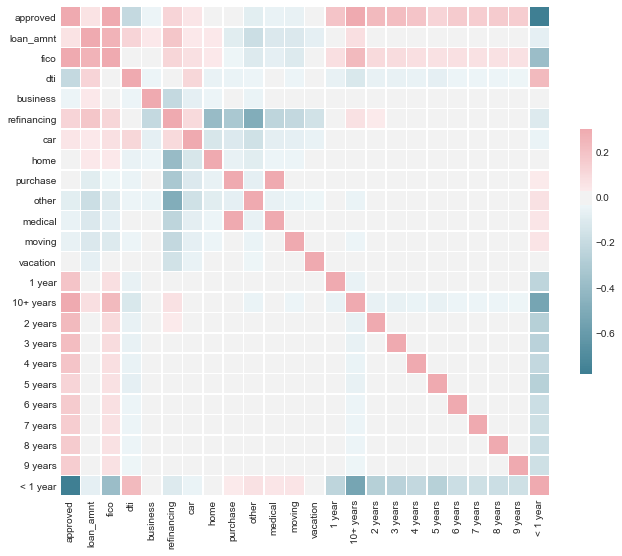

In [9]:
def corr_heatmap(df):
    corr = df.corr()
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr_heatmap(loan[loan.columns[0:25]])


#### 3.2 PCA plot
PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction and engineering, and much more.

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

### 4 Build models 
- KNN
- Logistic 
- SVM
- Decision Tree
- Random Tree

#### 4.1 Split data to test and train
Split Train and test <br>
Train set issued from before 2017-04-30<br>
Test  set issued from after 2017-05-01 

In [10]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier,RandomForestClassifier
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE 
from collections import Counter

In [11]:
loan_test = loan[loan.application_d > '2017-05-01'].copy()
loan_test.drop(['application_d'], axis=1,inplace=True)
loan = loan[loan.application_d < '2017-05-01']
loan.drop(['application_d'], axis=1,inplace=True)

In [29]:
y = loan['approved']
X = loan.iloc[:,1:]
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,stratify=y,random_state=55)
Counter(y)

Counter({0: 426436, 1: 184547})

#### 4.2 Standardlized the train data and fit scaler to test dataset

In [30]:
def standardlize(train,test,X):
    col = ['loan_amnt', 'fico', 'dti']
    scaler = preprocessing.StandardScaler()
    sc_train = scaler.fit_transform(train[col])
    sc_test  = scaler.transform(test[col])
    sc_X     = scaler.transform(X[col])
    train = pd.concat([pd.DataFrame(sc_train, columns=col),train.iloc[:,3::].reset_index(drop=True)],axis=1)
    test = pd.concat([pd.DataFrame(sc_test, columns=col),test.iloc[:,3::].reset_index(drop=True)],axis=1)
    X = pd.concat([pd.DataFrame(sc_X, columns=col),X.iloc[:,3::].reset_index(drop=True)],axis=1)
    return train, test, X

def min_max_scaler(df):
    scaler = preprocessing.MinMaxScaler()
    scaled_df = scaler.fit_transform(df)
    df = pd.DataFrame(scaled_df, columns=df.columns)
    return df

x_train,x_test,X = standardlize(x_train,x_test,X)

In [31]:
# x_train[x_train.isnull().any(axis=1)]
x_train.columns

Index(['loan_amnt', 'fico', 'dti', 'business', 'refinancing', 'car', 'home', 'purchase', 'other', 'medical', 'moving', 'vacation', '1 year', '10+ years', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '< 1 year', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype='object')

#### 4.3  Develop model baseline - Train/test approach
- Logistic
- Naive Bayes
- KNN model
- SVM linear / rbf 
- Decision Tree
- Random Forest

SVM is not a good model in this project

In [15]:
def train_test_baseline(model,name):
    if name == 'svm rbf' or name == 'svm linear' or name=='KNN':
        model.fit(x_train[10000:15000], y_train[10000:15000])
    else:
        model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    precision,recall,f1,_ = precision_recall_fscore_support(y_test, y_pred,average='binary')
    return name,round(precision,2),round(recall,2),round(f1,2)


model_name = [(linear_model.LogisticRegression(),'Logistic'),
              (GaussianNB(),'Naive Bayes'),
              (neighbors.KNeighborsClassifier(),'KNN'),
#               (svm.LinearSVC(),'svm linear'),
#               (svm.SVC(kernel='rbf'),'svm rbf'),
              (DecisionTreeClassifier(),'Decision tree'),
              (RandomForestClassifier(),'Random forest')]
tmp = []
# for model in model_name:
#     tmp.append(train_test_baseline(model[0],model[1]))
# print ('*********** Train test split   ********')
# pd.DataFrame(data=tmp,columns=['model name','precision','recall','f1'])

#### 4.4 Balance the training dataset using SMOTE or class weights

The original dataset is slightly imbalanced with the 0:1 ratio (rejected:accpeted) equals 4:1. In real life it is often the case. In this case, a small portion of observations successfully received the loans from Lending club. One of approaches is to oversample the minority class observations to improve the precision recall score. Sometimes, models learn better but it is not always the case. Therefore we test the oversample strategy using a powerful tool Smote.

[From Nick Becker's data scientist blog](https://beckernick.github.io/oversampling-modeling/)<br>
SMOTE creates synthetic observations of the minority class (bad loans) by:
- Finding the k-nearest-neighbors for minority class observations (finding similar observations)
- Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observation.

Smote signifcantly improved KNN, naive bayes and logisitc but not the decision trees or random forest
Class weights work nicely on logistic regression

In [ ]:
print ('*********** Balance the dataset   ********')
sm = SMOTE(random_state=100,ratio=1)
x_smote, y_smote = sm.fit_sample(x_train, y_train)
print (Counter(y_smote))

def model_smote(model,name):
    model.fit(x_smote, y_smote)
    y_pred = model.predict(x_test)
    precision,recall,f1,_ = precision_recall_fscore_support(y_test, y_pred,average='binary')
    return name,round(precision,2),round(recall,2),round(f1,2)

model_name_smote = [
              (linear_model.LogisticRegression(),'Logistic smote'),
              (GaussianNB(),'Naive Bayes smote'),
#               (neighbors.KNeighborsClassifier(),'KNN smote'),
              (DecisionTreeClassifier(),'Decision tree smote'),
              (RandomForestClassifier(),'Random forest smote')]

model_class_weight = [(linear_model.LogisticRegression(class_weight='balanced'),'Logistic CW'),
                      (DecisionTreeClassifier(class_weight='balanced'),'Decision tree CW'),
                      (RandomForestClassifier(class_weight='balanced'),'Random forest CW')]
tmp = []
for model in model_name_smote:
    tmp.append(model_smote(model[0],model[1]))
for model in model_class_weight:
    tmp.append(train_test_baseline(model[0],model[1]))
pd.DataFrame(data=tmp,columns=['model name','precision','recall','f1'])


*********** Balance the dataset   ********


/Users/mumuxi/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


#### 4.5 Gridsearch
Random Forest max_depth = 2 with precision = 0.87<br>
Decision tree max_depth = 18 with precision = 0.87<br>
Logistic Regression C = any  <br>
KNN best K = 19, weights = 'uniform' <br>

In [52]:
knn_grid = {
    "n_neighbors": np.arange(1,20,2),
    "weights": ["uniform", "distance"]}

tree_grid = {
    "max_depth": np.arange(1,20,1)}

log_grid = {"C":np.logspace(-2,1,10)}

def grid_search(model,param_grid):
    grid = GridSearchCV(model, param_grid, cv=5, scoring='precision',n_jobs=8)
    grid.fit(x_train[10000:15000], y_train[10000:15000]);
    print(grid.best_score_)
    print(grid.best_params_)
#     y_pred = grid.predict(x_test)
#     precision,recall,f1,_ = precision_recall_fscore_support(y_test, y_pred,average='binary')
#     return round(precision,2),round(recall,2),round(f1,2)
        
# grid_search(RandomForestClassifier(),tree_grid) 
# grid_search(DecisionTreeClassifier(),tree_grid) 
# grid_search(linear_model.LogisticRegression(),log_grid) 
# grid_search(neighbors.KNeighborsClassifier(),knn_grid) 

0.7000637747389483
{'n_neighbors': 19, 'weights': 'distance'}


#### 4.6 Lasso Regression and coefficients
- what are the dominant features ?

Here we use logistic model as the sample, because it is quick to run. <br>
Laso significantly improved recall score.

In [47]:
lr_lasso = linear_model.LogisticRegression(penalty='l1', solver='liblinear')

# train_test_baseline(lr_lasso,'Logistic Lasso')

In [ ]:
def lasso_log(name):
    lr_lasso.fit(x_train, y_train)
    y_pred = lr_lasso.predict(x_test)
    coe = pd.DataFrame(data=tmp,columns=['model name','precision','recall','f1'])
    ind = np.arange(len(x_train.columns))
    fig = plt.subplots(figsize=(20,8))
    plt.scatter(ind, lr_lasso.coef_)
    plt.xticks(ind, x_train.columns, rotation=90);
    plt.title("Top coefficients for logistic lasso regression  model")
    plt.ylabel("coefficient");
    return  pd.DataFrame(data=list(zip(x_test.columns.tolist(),lr_lasso.coef_[0])),columns=['features','coef'])
lgr_coe = lasso_log('logistic with lasso ') 

#### 4.7 Cross Val 
- Add class_weight = 'balanced' to logistic regression

In [27]:
def cross_val_baseline(model,name):
##  cut sample size for KNN to run faster
    print (name)
    if name == 'KNN':
        X_sample = x_smote[10000:11000]
        y_sample = y_smote[10000:11000]
    if name == 'Naive Bayes':
        X_sample = x_smote
        y_sample = y_smote
    else:
        X_sample = X
        y_sample = y
    sc = model_selection.cross_validate(model, X_sample,y_sample,n_jobs=8,
                                        cv=10,scoring=['f1','precision','recall'],return_train_score=False)
    return name,round(np.mean(sc['test_precision']),3),round(np.mean(sc['test_recall']),3),round(np.mean(sc['test_f1']),3)

model_name = [
              (lr_lasso,'Logistic Lasso'),
              (GaussianNB(),'Naive Bayes '),
              (neighbors.KNeighborsClassifier(),'KNN Smote'),
              (DecisionTreeClassifier(),'Decision tree'),]
              (RandomForestClassifier(),'Random forest')]
tmp = []
print ('*********** Cross Val   ********')
for model in model_name:
    tmp.append(cross_val_baseline(model[0],model[1]))
pd.DataFrame(data=tmp,columns=['model name','precision','recall','f1'])

Naive Bayes Smote


/Users/mumuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mumuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mumuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mumuxi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mumuxi/anaconda3/lib/python3.6/site-packages/

Decision tree
*********** Cross Val   ********
          model name  precision  recall     f1
0  Naive Bayes Smote      0.000   0.000  0.000
1      Decision tree      0.852   0.855  0.852


Text(0.5,1,'Model Comparsion')

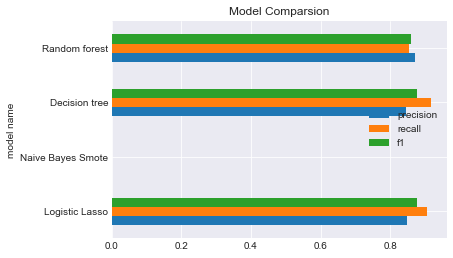

In [25]:
model_rs.index=model_rs['model name']
model_rs.plot.barh();
plt.title('Model Comparsion')

#### 4.8 Feature Importance

In [73]:
# feature_importances_
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf_coe = pd.DataFrame(data=list(zip(x_train.columns.values, rf.feature_importances_)),
                         columns=['features','importance'])
rf_coe.sort_values(by='importance',ascending=False,inplace=True)
rf_coe['features'].values
print (rf_coe)

# u_pre = []
# u_recall = []
# for i in range(1,len(rf_coe),5):
#     print (i)
#     rf.fit(x_train.iloc[:,0:i], y_train)
#     y_pred = rf.predict(x_test.iloc[:,0:i])
#     precision,recall,f1,_ = precision_recall_fscore_support(y_test, y_pred,average='binary')
#     u_pre.append(precision)
#     u_recall.append(recall)

KeyboardInterrupt: 

Text(0,0.5,'Abs Importance')

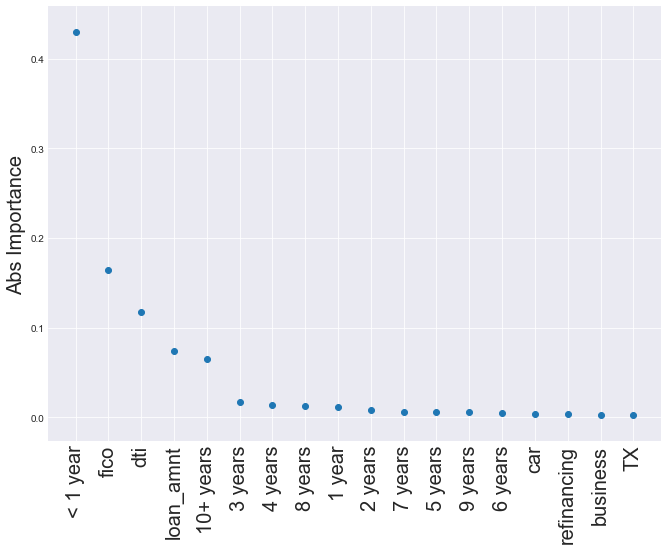

In [109]:
# rf_coe.index=rf_coe.features
f, ax = plt.subplots(figsize=(11, 8))
rf_coe1 = rf_coe[0:18]
ax.scatter(range(len(rf_coe1)),rf_coe1.importance)
ax.set_xticks(range(len(rf_coe1)))
ax.set_xticklabels(rf_coe1.index.values,size = 20)
plt.xticks(rotation=90)
ax.set_ylabel('Abs Importance',size=20)

In [33]:
dtree = DecisionTreeClassifier()
dtree.fit(x_train, y_train)
dtree_coe = pd.DataFrame(data=list(zip(x_train.columns.values, dtree.feature_importances_)),
                         columns=['features','importance'])
dtree_coe.sort_values(by='importance',ascending=False,inplace=True)
dtree_coe['features'].values
v_pre = []
v_recall = []
for i in range(1,len(dtree_coe),5):
    print (i)
    dtree.fit(x_train.iloc[:,0:i], y_train)
    y_pred = dtree.predict(x_test.iloc[:,0:i])
    precision,recall,f1,_ = precision_recall_fscore_support(y_test, y_pred,average='binary')
    v_pre.append(precision)
    v_recall.append(recall)

1
6
11
16
21
26
31
36
41
46
51
56
61
66
71


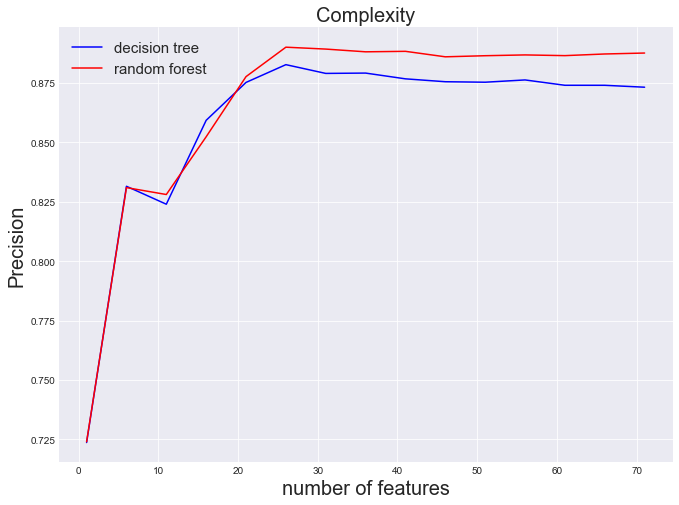

In [42]:
f, ax = plt.subplots(figsize=(11, 8))
plt.plot(range(1,len(rf_coe),5),u_pre,color='blue',label='decision tree')
plt.plot(range(1,len(rf_coe),5),v_pre,color='red',label='random forest')
plt.ylabel('Precision',size = 20)
plt.xlabel('number of features',size = 20)
plt.title('Complexity',size = 20)

plt.legend(prop={'size': 15})

#### 4.9 Visualizing Decision Trees with Python
So far the best model is random forest, constructing a multitude of decision trees. So let's visualize decision tree

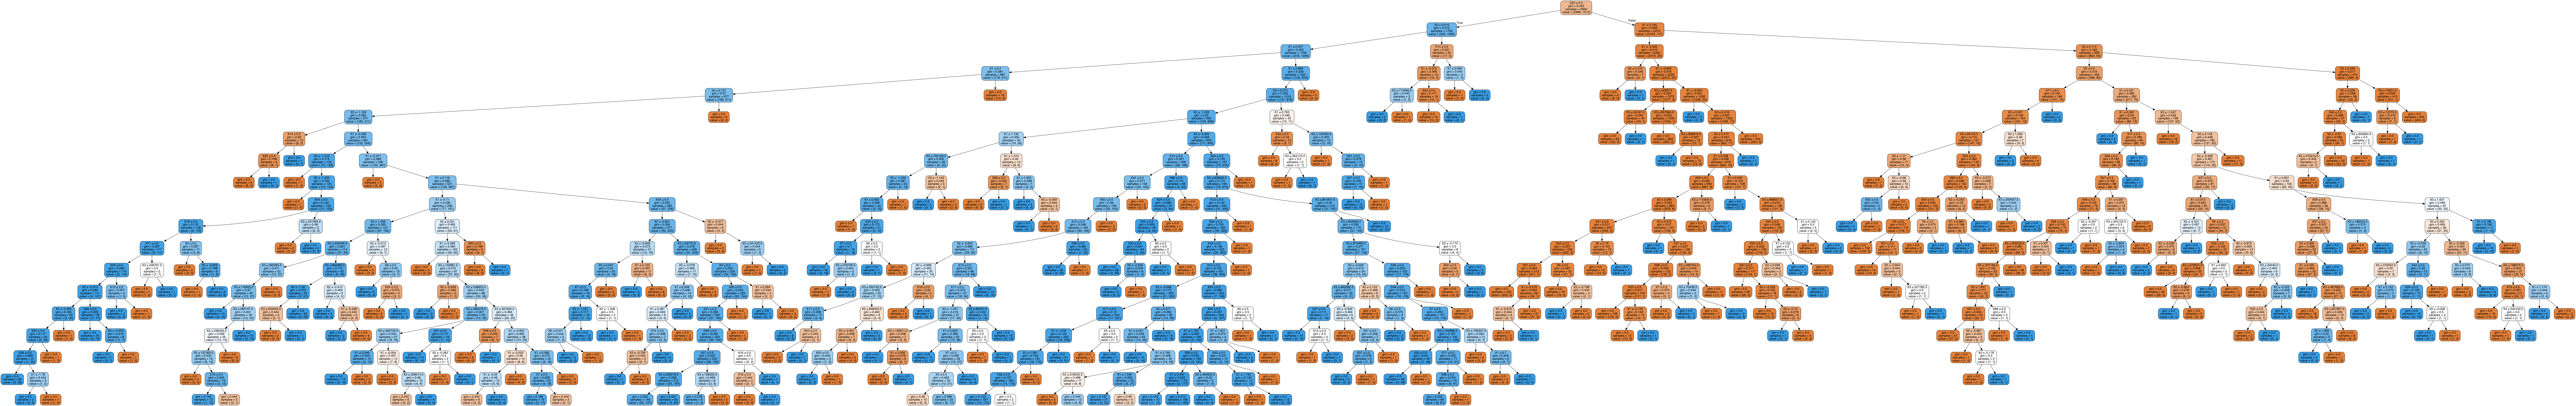

In [74]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
dtree=DecisionTreeClassifier(max_depth=18)
dtree.fit(x_train[0:5000],y_train[0:5000])
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### 5 Error Analysis
- confusion matrix (recall, precision)
- ROC/AUC curve
- Precision recall curve(Find threshold and determine what is 1 and what is 0)  i.e good threshold would b 0.8
- thresholding curve
- determine whether underfit or overfit

In a ROC curve the true positive rate (Sensitivity) is plotted in function of the false positive rate (100-Specificity) for different cut-off points of a parameter. Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold. The area under the ROC curve (AUC) is a measure of how well a parameter can distinguish between two diagnostic groups (diseased/normal).

- Sensitivity/recall – Does it detect all positives ?
- Specificity – how good a test is at avoiding false alarms. A test can cheat and maximize this by always returning “negative”.
- Precision – how many of the positively classified were relevant. A test can cheat and maximize this by only returning positive on one result it’s most confident in.

In [44]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import random

In [51]:
def roc_curve_plot(y_test,y_proba,name):
    fpr, tpr,_ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr,label=name+' AUC:'+str(round(roc_auc,3)))
    plt.xlabel('FPR',size=20)
    plt.ylabel('TPR',size=20)

def model_train_test(model,name):
    if name == 'KNN':
        model.fit(x_train[10000:11000], y_train[10000:11000])
    else:
        model.fit(x_train, y_train)
    y_pred = model.predict(x_test)   
    y_p = model.predict_proba(x_test)[:,1]
    roc_curve_plot(y_test.values,y_p,name)
    plt.legend(prop={'size': 15})
    
lr_lasso = linear_model.LogisticRegression(penalty='l1', solver='liblinear')


/Users/mumuxi/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


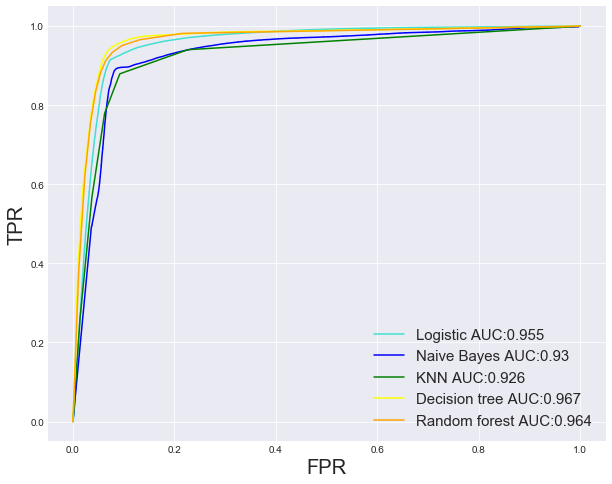

In [52]:
model_name = [
              (lr_lasso,'Logistic'),
              (GaussianNB(),'Naive Bayes'),
              (neighbors.KNeighborsClassifier(n_jobs=8),'KNN'),
              (DecisionTreeClassifier(max_depth=18),'Decision tree'),
              (RandomForestClassifier(n_jobs=8),'Random forest')]
fig, ax = plt.subplots(figsize=(10,8))
ax.set_color_cycle(['turquoise', 'blue', 'green','yellow','orange'])
for model in model_name:
    model_train_test(model[0],model[1])
    


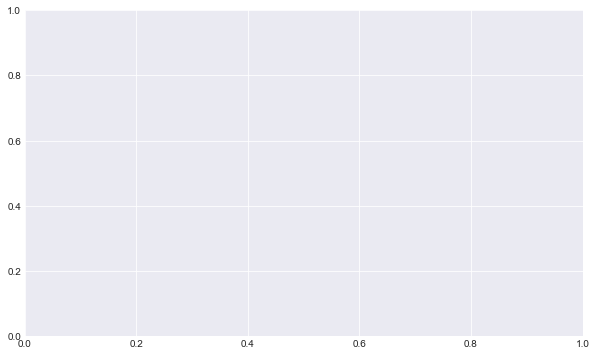

In [53]:
def precision_recall_plot(y_test,y_p,name):
    p,r,t=precision_recall_curve(y_test,y_p)
#     adding last threshold of '1' to threshold list
    t=np.vstack([t.reshape([-1,1]),1])
    plt.plot(t,p,label='Precision')
    plt.plot(t,r,label='Recall');
    plt.title('Precision Recall Curve');
    plt.legend()
    
fig, ax = plt.subplots(figsize=(10,6))   
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
y_p = rf.predict_proba(x_test)[:,1]
# precision_recall_plot(y_test.values,y_p,'Random Forest')


[[120837   7094]
 [  6533  48831]]


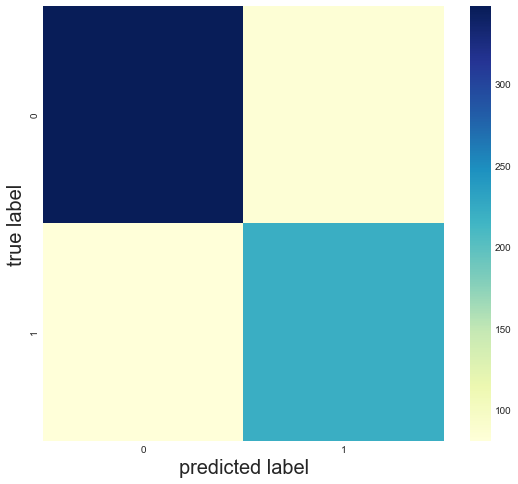

In [71]:
def plot_confusion(clf, x, y):
    y_pred = clf.predict(x)
    c_mat = confusion_matrix(y,y_pred)
    print (c_mat)
    labels = np.unique(y)
    sns.heatmap(
        np.sqrt(c_mat),
        cmap="YlGnBu",
        xticklabels=labels,
        yticklabels=labels,
        cbar=True);
    plt.ylabel("true label",size=20)
    plt.xlabel("predicted label",size=20)
f, ax = plt.subplots(figsize=(9, 8))    
plot_confusion(rf,x_test,y_test)

#### Appendix Web Application

In [39]:
import pickle
with open("rf.pkl", "wb") as f:
    pickle.dump(rf, f)

In [62]:
x_test[0:1].values
x_test.columns.values[23::]

array(['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
       'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI',
       'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV',
       'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
       'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

In [64]:
ttt = np.array([[-1.2687322044058145, -8.224727838258165, 9.0976290097629, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
rf.predict(ttt)

array([1])

#### Appendix  Decision Boundries - Carry on study of svm 
- Tried 3 kernel function: linear, rbf and poly
- Plot decision boundary

In [ ]:
titles = ['SVC with linear kernel','LinearSVC (linear kernel)',
          'SVC with RBF kernel','SVC with polynomial (degree 3) kernel']

clf1,clf2,clf3,clf4= svm.SVC(kernel='linear'),svm.LinearSVC(),
                     svm.SVC(kernel='rbf', gamma=0.7),svm.SVC(kernel='poly', degree=3, C=1)

# eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
# ('svc', clf3)],voting='soft', weights=[2, 1, 2])

X_ = X[['fico','dti']][0:1500]
y_ = y[0:1500]
x_min, x_max = X_.iloc[:, 0].min() - 1, X_.iloc[:, 0].max() + 1
y_min, y_max = X_.iloc[:, 1].min() - 1, X_.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),np.arange(y_min, y_max, 0.1))

clf1.fit(X_, y_)
clf2.fit(X_, y_)
clf3.fit(X_, y_)
clf4.fit(X_, y_)

# Plotting decision regions
f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(15, 10))
for idx, clf, tt in zip(itertools.product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, clf4],
                        titles):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X_.iloc[:, 0], X_.iloc[:, 1], c=y_, s=20, edgecolor='k',alpha=0.5)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

EDA 

In [122]:
sql_line_rej = '''
SELECT COUNT(*),SUBSTR(application_d,1,4) as ddate
FROM rej
GROUP BY
ddate
'''

sql_line_acc = '''
SELECT COUNT(*),SUM(loan_amnt)/1000000,SUBSTR(issue_d,5,4) as ddate
FROM acc
GROUP BY
ddate
'''

# SELECT * FROM (SELECT COUNT(*),SUBSTR(application_d,5,4) as dddate
# FROM rej GROUP BY dddate) AS one JOIN (SELECT COUNT(*),SUM(acc.loan_amnt),SUBSTR(acc.issue_d,5,4) as ddate
# FROM acc GROUP BY
# ddate) AS two
# WHERE one.dddate = two.ddate;

In [123]:
def read_reject():
    conn = sqlite3.connect(sql_file)
    cur = conn.cursor()
    df = pd.DataFrame(cur.execute(sql_line_rej).fetchall(),
                      columns=['applications','year'])
    return df
def read_accept():
    conn = sqlite3.connect(sql_file)
    cur = conn.cursor()
    df = pd.DataFrame(cur.execute(sql_line_acc).fetchall(),
                      columns=['applications','loan_amnt','year'])
    return df
def EDA():
    acc = read_accept()
    rej = read_reject()
    print (acc)


    acc = acc.merge(rej,how='outer',on='year')
    return acc
    
eda = EDA()

    applications    loan_amnt  year
0            603     4.977475  2007
1           2393    21.119250  2008
2           5281    51.928250  2009
3          12537   131.992550  2010
4          21721   261.683825  2011
5          53367   718.411025  2012
6         134814  1982.765275  2013
7         235629  3503.840175  2014
8         421095  6417.608175  2015
9         434407  6400.569700  2016
10        324931  4767.602950  2017


In [125]:
eda['total'] = (eda.applications_x+eda.applications_y)/1000
eda['rej_rates'] = eda.applications_y/eda.total/10

In [130]:
eda

applications_x    loan_amnt  year  applications_y     total  rej_rates
0              603     4.977475  2007            5274     5.877  89.739663
1             2393    21.119250  2008           25596    27.989  91.450213
2             5281    51.928250  2009           56991    62.272  91.519463
3            12537   131.992550  2010          112561   125.098  89.978257
4            21721   261.683825  2011          217792   239.513  90.931181
5            53367   718.411025  2012          337277   390.644  86.338712
6           134814  1982.765275  2013          760942   895.756  84.949696
7           235629  3503.840175  2014         1933700  2169.329  89.138162
8           421095  6417.608175  2015         2859379  3280.474  87.163593
9           434407  6400.569700  2016         4769874  5204.281  91.652891
10          324931  4767.602950  2017         5052086  8148.017  93.957040

Text(0,0.5,'Number of Applications in thousands')

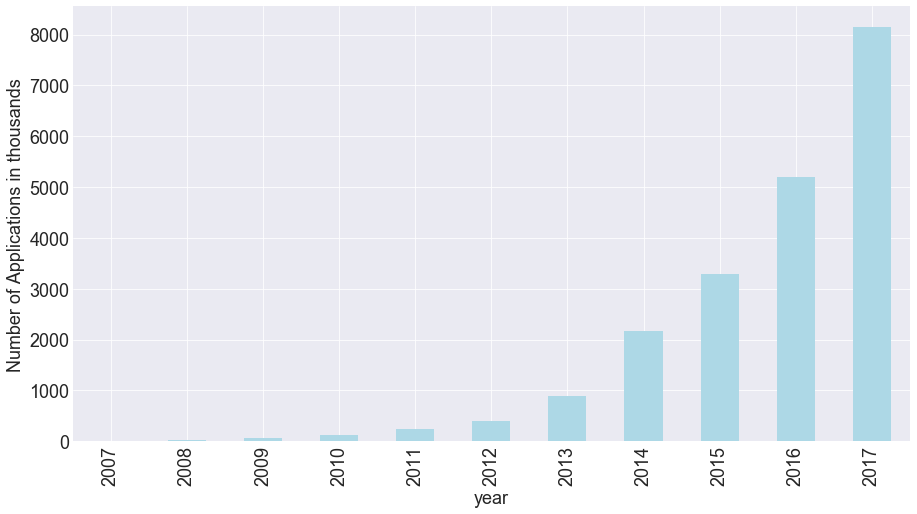

In [131]:
eda.loc[10,'total'] = 5377.017 + 2771
eda.index=eda['year']
f, ax = plt.subplots(figsize=(15, 8))
eda.total.plot.bar(color='lightblue', fontsize=18)
ax.set_xlabel('year',size=18)
ax.set_ylabel('Number of Applications in thousands',size=18)